# Character Dataset Cleaning

In this notebook, we will focus on examining the "characters.metadata.tsv" dataset, with particular attention to the age and gender of actors. Rather than integrating all character attributes, our primary objective is to analyze how actor demographics might influence a movie’s appeal and performance. By studying and cleaning the age and gender features specifically, we aim to extract insights that can contribute to a deeper understanding of casting trends and audience preferences in preparation for Milestone 3.

### Loading the Dataset

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

In [2]:
folder = '../data/CMU/'
pickle_folder = "../data/pickle/"

In [3]:
character_original_data = pd.read_csv(folder + 'character.metadata.tsv',sep='\t',names=['Wikipedia_movie_ID',
'Freebase_movie_ID',
'Movie_release_date',
'Character_name',
'Actor_date_of_birth',
'Actor_gender',
'Actor_height_(in_meters)',
'Actor_ethnicity_(Freebase_ID)',
'Actor_name',
'Actor_age_at_movie_release',
'Freebase_character/actor_map_ID',
'Freebase_character_ID',
'Freebase_actor_ID'])

with open(pickle_folder + "movies_clean.p", "rb" ) as f:
    movies = pickle.load(f)

with open(pickle_folder + "movies_clean_with_season.p", "rb" ) as f:
    movies_season = pickle.load(f)

In [4]:
characters = character_original_data.copy()

In [5]:
print(characters.shape[0])

450669


## 1. Cleaning and adding features

- First, we combine the character dataframe with the movies_cleaned dataframe to drop all the movies. The goal is to benefeciate from the already preprocessed release date of movies of the movies_clean dataframe, as well as adding all features like average rating, Year, Year Interval, box office revenue, numVotes or the release season of the movie of each character.
This also allows us to eliminate movies that have a lot of missing data and to focus more on characters that comes from movies for which we have some informations.
- As printed below, this leave us with more than 270 000 characters and 33 000 movies.

In [6]:
cd = characters.drop(columns=['Movie_release_date', 
                         'Freebase_movie_ID', 
                         'Character_name',
                         'Actor_height_(in_meters)',
                         'Actor_ethnicity_(Freebase_ID)',
                         'Freebase_character/actor_map_ID',
                         'Freebase_character_ID',
                         'Freebase_actor_ID'
                        ])

cd = cd.merge(movies_season[['Wikipedia_movie_ID', 
                 'Movie_name',
                 'Movie_release_date', 
                 'Movie_box_office_revenue',
                 'Year', 
                 'Year_Interval', 
                 'averageRating', 
                 'numVotes',
                'release_season'
                ]],how='inner', on='Wikipedia_movie_ID')

print(f"Number of characters in the dataset : {len(cd)}")
print(f"Number of movies in the dataset : {len(cd.groupby('Wikipedia_movie_ID'))}")

Number of characters in the dataset : 271656
Number of movies in the dataset : 33337


In [7]:
cd.sample(5)

,Wikipedia_movie_ID,Actor_date_of_birth,Actor_gender,Actor_name,Actor_age_at_movie_release,Movie_name,Movie_release_date,Movie_box_office_revenue,Year,Year_Interval,averageRating,numVotes,release_season
232532,19312200,1920-08-09,M,Allen Hoskins,6.0,The Fourth Alarm,1926-09-12,NaN,1926,1915-1935,NaN,NaN,Autumn
269402,308430,1980-04-26,F,Jordana Brewster,18.0,The Faculty,1998-12-25,40283321.0,1998,1995-2015,NaN,NaN,Winter
228003,35575079,1921-08-08,F,Esther Williams,30.0,Skirts Ahoy!,1952-05-28,2500000.0,1952,1935-1955,NaN,NaN,Spring
253686,338962,NaN,M,Patrick Cronin,NaN,Splash,1984-03-09,69821334.0,1984,1975-1995,7.0,219.0,Spring
127873,5239682,1966-07-31,M,Dean Cain,39.0,10.5: Apocalypse,2006-03-18,NaN,2006,1995-2015,NaN,NaN,Spring


- Now, we proceed to check if the release_date have the correct format, i.e. that there are no movies before 1888 (date of the first movie in history) and after 2016 (known limit of the dataset)

In [8]:
test = cd.copy()
test['Year'].describe()

count    271656.000000
mean       1986.299206
std          25.450334
min        1915.000000
25%        1972.000000
50%        1997.000000
75%        2006.000000
max        2014.000000
Name: Year, dtype: float64

- Check if monthes have the correct format (superior to 0 and inferior to 13) 

In [9]:
test = cd.copy()
test['mois'] = test['Movie_release_date'].astype(str).str.split('-').str[1]
test['mois'] = test['mois'].astype(int)
test['mois'].describe()

count    271656.000000
mean          6.740974
std           3.453710
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: mois, dtype: float64

- Check if days have the correct format (superior to 0 and inferior to 32) 

In [10]:
test['jour'] = test['Movie_release_date'].astype(str).str.split('-').str[2]
test['jour'] = test['jour'].astype(int)
test['jour'].describe()

count    271656.000000
mean         15.684966
std           8.588049
min           1.000000
25%           9.000000
50%          16.000000
75%          23.000000
max          31.000000
Name: jour, dtype: float64

- Now that we are confident about the correct format of the release date we can continue with the others feature

## 2. Cleaning Gender of Actors

- We now proceed to the conversion of the "Actor_gender" feature (which contains either 'M' for Male or 'F' for Female, both being strings) into two features "gender_F" and "gender_M" (which will contains only boolean variable True or False). Hence, as seen in Exercise 6, we use the method get_dummies from pandas

In [11]:
cd_actors = cd.copy()
cd_actors.dropna(subset="Actor_gender",inplace = True)
dummies = pd.get_dummies(cd_actors['Actor_gender'], prefix = 'gender')
cd_actors = cd_actors.merge(dummies, left_index=True, right_index=True)
cd_actors

,Wikipedia_movie_ID,Actor_date_of_birth,Actor_gender,Actor_name,Actor_age_at_movie_release,Movie_name,Movie_release_date,Movie_box_office_revenue,Year,Year_Interval,averageRating,numVotes,release_season,gender_F,gender_M
0,975900,1958-08-26,F,Wanda De Jesus,42.0,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False
1,975900,1974-08-15,F,Natasha Henstridge,27.0,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False
2,975900,1969-06-15,M,Ice Cube,32.0,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,False,True
3,975900,1967-09-12,M,Jason Statham,33.0,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,False,True
4,975900,1977-09-25,F,Clea DuVall,23.0,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271651,913762,1954,M,Sonny Byrkett,38.0,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,False,True
271652,913762,1958,F,Susan Byrkett,34.0,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,True,False
271653,913762,NaN,M,Hal Cleaveland,NaN,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,False,True
271654,913762,1970-05,F,Dorothy Elias-Fahn,NaN,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,True,False


- Here, we verify that all the values for the XOR are True (which means either gender_F is true or gender_M is true)

In [12]:
test['XOR'] = cd_actors['gender_F'] ^ cd_actors['gender_M']
test['XOR'].describe()

count     251167
unique         1
top         True
freq      251167
Name: XOR, dtype: object

In [13]:
with open(pickle_folder+"characters_clean.p", "wb" ) as f:
    cd = cd_actors
    pickle.dump(cd,f)

## 3. Verify the correctness of the age of actors

### 3.1. Dropping missing data

- In this part the goal is to find all the errors involving the age of actors, so first we drop all the rows where actor's date of birth are not given

In [14]:
cd_actorYear = cd.copy()
print(f"Number of actors dropped : {cd_actorYear.Actor_date_of_birth.isna().sum()}")
cd_actorYear.dropna(subset = 'Actor_date_of_birth', inplace = True)
cd_actorYear

Number of actors dropped : 40708


,Wikipedia_movie_ID,Actor_date_of_birth,Actor_gender,Actor_name,Actor_age_at_movie_release,Movie_name,Movie_release_date,Movie_box_office_revenue,Year,Year_Interval,averageRating,numVotes,release_season,gender_F,gender_M
0,975900,1958-08-26,F,Wanda De Jesus,42.0,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False
1,975900,1974-08-15,F,Natasha Henstridge,27.0,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False
2,975900,1969-06-15,M,Ice Cube,32.0,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,False,True
3,975900,1967-09-12,M,Jason Statham,33.0,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,False,True
4,975900,1977-09-25,F,Clea DuVall,23.0,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271650,913762,1954,M,Sonny Byrkett,38.0,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,False,True
271651,913762,1954,M,Sonny Byrkett,38.0,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,False,True
271652,913762,1958,F,Susan Byrkett,34.0,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,True,False
271654,913762,1970-05,F,Dorothy Elias-Fahn,NaN,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,True,False


### 3.2. Verification of the year of birth of actors 

In [15]:
cd_actorYear['Year_of_birth'] = cd_actorYear['Actor_date_of_birth'].str[:4].astype(int)

# Print les 20 acteurs les plus jeunes du dataset
cd_actorYear.sort_values(by='Year_of_birth',ascending=False)

,Wikipedia_movie_ID,Actor_date_of_birth,Actor_gender,Actor_name,Actor_age_at_movie_release,Movie_name,Movie_release_date,Movie_box_office_revenue,Year,Year_Interval,averageRating,numVotes,release_season,gender_F,gender_M,Year_of_birth
269086,3642891,2936-12-24,F,J.J. McColl,-937.0,Road Rage,1999-10-03,NaN,1999,1995-2015,5.9,18.0,Autumn,True,False,2936
180380,22643470,2896-04-26,M,Matthieu van Eysden,-969.0,Artistenrevue,1926-10-29,NaN,1926,1915-1935,7.6,10834.0,Autumn,False,True,2896
207918,34654608,2050,M,Naozumi Takahashi,-37.0,Mameshiba Ichirō 3D,2012-02-04,NaN,2012,1995-2015,NaN,NaN,Winter,False,True,2050
245981,206818,2011-09-02,M,John Cassini,-15.0,Seven,1995-09-22,NaN,1995,1975-1995,7.0,1075.0,Autumn,False,True,2011
216550,15564747,2011-09-02,M,John Cassini,-4.0,Love and Other Dilemmas,2006-10-10,NaN,2006,1995-2015,NaN,NaN,Autumn,False,True,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156173,35340704,1796-09-20,M,Robert Strange,NaN,The Cheat,1931-11-28,NaN,1931,1915-1935,NaN,NaN,Autumn,False,True,1796
171177,35201805,1498,F,Mirabai,NaN,Ishq Khuda,2012-08-18,NaN,2012,1995-2015,NaN,NaN,Summer,True,False,1498
103304,24870348,1075-08-19,F,Holly Eglington,NaN,Stan Helsing,2009-10-21,11014125.0,2009,1995-2015,NaN,NaN,Autumn,True,False,1075
221846,17683199,1075-08-19,F,Holly Eglington,NaN,Ruslan,2009-05-19,NaN,2009,1995-2015,NaN,NaN,Spring,True,False,1075


- Hence, we remark that there is some actors for which the year of birth was wrongly given to us. We hence decided to remove first all actors where their year of birth is superior to 2014 and inferior to 1800 (because we study the period between 1915 and 2015) : 

In [16]:
cd_actorYear = cd_actorYear[cd_actorYear['Year_of_birth'] <= 2014]
cd_actorYear = cd_actorYear[cd_actorYear['Year_of_birth'] >= 1800]
cd_actorYear.sort_values(by='Year_of_birth').tail(20)

,Wikipedia_movie_ID,Actor_date_of_birth,Actor_gender,Actor_name,Actor_age_at_movie_release,Movie_name,Movie_release_date,Movie_box_office_revenue,Year,Year_Interval,averageRating,numVotes,release_season,gender_F,gender_M,Year_of_birth
182700,33367792,2006-11,F,Gwendolyn Göbel,NaN,Goethe,2010-10-14,NaN,2010,1995-2015,5.9,167440.0,Autumn,True,False,2006
207717,22928463,2006-07-15,M,Senne Rouffaer,-27.0,Woman Between Wolf and Dog,1979-05-16,NaN,1979,1975-1995,6.1,284.0,Spring,False,True,2006
90856,31882143,2006,F,Sara Arjun,5.0,Gods Own Child,2011-07-15,NaN,2011,1995-2015,NaN,NaN,Summer,True,False,2006
64849,22933412,2006-05-06,F,Sadie Madison Sandler,4.0,Grown Ups,2010-06-24,271430189.0,2010,1995-2015,6.0,511.0,Summer,True,False,2006
89090,16204877,2006-05-06,F,Sadie Madison Sandler,2.0,Bedtime Stories,2008-12-24,212874442.0,2008,1995-2015,NaN,NaN,Winter,True,False,2006
191526,8031432,2006-05-27,F,Shiloh Jolie-Pitt,2.0,The Curious Case of Benjamin Button,2008-12-10,333932083.0,2008,1995-2015,NaN,NaN,Winter,True,False,2006
109861,26107567,2006-05-06,F,Sadie Madison Sandler,4.0,Just Go With It,2011-02-09,214918407.0,2011,1995-2015,6.5,124.0,Winter,True,False,2006
117154,32298508,2008-10-29,M,Owen Bento,2.0,Friends with Kids,2011-09-09,12186625.0,2011,1995-2015,7.4,117.0,Autumn,False,True,2008
266575,27111227,2008-05-31,F,Brooke Clagett,2.0,Life as We Know It,2010-10-02,105648706.0,2010,1995-2015,NaN,NaN,Autumn,True,False,2008
50971,34537226,2008-01-10,M,Finn Donoghue,4.0,Price Check,2012-01-25,NaN,2012,1995-2015,7.6,84.0,Winter,False,True,2008


- We also decided to recompute Actor_age_at_movie_release as it is not given for all rows. Thus, we can compensate the missing data by substracting the year_of_birth of an actor to the Year of release of their movie.

In [17]:
cd_actorYear['Actor_age_at_movie_release'] = cd_actorYear["Year"]-cd_actorYear["Year_of_birth"]
cd_actorYear['Actor_age_at_movie_release'].describe()

count    210451.000000
mean         39.364769
std          14.515317
min         -54.000000
25%          29.000000
50%          38.000000
75%          49.000000
max         153.000000
Name: Actor_age_at_movie_release, dtype: float64

- Then, by observing the desribe() method, we notice negative age of actors at movie release which is impossible. Hence, decided to quantify how many outliers we had.

In [18]:
test = cd_actorYear[cd_actorYear['Actor_age_at_movie_release'] <= 0]
len(test)

205

- Then, we decided to handle these incoherence in the dataset by removing them because of the weak proportion of actors 'outliers' compared to the size of the dataset (200/200000 = 0.1%)


In [19]:
cd_actorYear = cd_actorYear[cd_actorYear['Actor_age_at_movie_release'] > 0]
cd_actorYear

,Wikipedia_movie_ID,Actor_date_of_birth,Actor_gender,Actor_name,Actor_age_at_movie_release,Movie_name,Movie_release_date,Movie_box_office_revenue,Year,Year_Interval,averageRating,numVotes,release_season,gender_F,gender_M,Year_of_birth
0,975900,1958-08-26,F,Wanda De Jesus,43,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False,1958
1,975900,1974-08-15,F,Natasha Henstridge,27,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False,1974
2,975900,1969-06-15,M,Ice Cube,32,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,False,True,1969
3,975900,1967-09-12,M,Jason Statham,34,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,False,True,1967
4,975900,1977-09-25,F,Clea DuVall,24,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False,1977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271650,913762,1954,M,Sonny Byrkett,38,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,False,True,1954
271651,913762,1954,M,Sonny Byrkett,38,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,False,True,1954
271652,913762,1958,F,Susan Byrkett,34,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,True,False,1958
271654,913762,1970-05,F,Dorothy Elias-Fahn,22,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,True,False,1970


- Finally, we wanted to see if there was old people as actors for certain movies :

In [20]:
test = cd_actorYear[cd_actorYear['Actor_age_at_movie_release'] >= 100]
test

,Wikipedia_movie_ID,Actor_date_of_birth,Actor_gender,Actor_name,Actor_age_at_movie_release,Movie_name,Movie_release_date,Movie_box_office_revenue,Year,Year_Interval,averageRating,numVotes,release_season,gender_F,gender_M,Year_of_birth
92507,18631737,1891-09-16,F,Stacia Napierkowska,121,The Hunchback of Notre Dame,2012-11-10,NaN,2012,1995-2015,NaN,NaN,Autumn,True,False,1891
92508,18631737,1866-04-26,M,Henry Krauss,146,The Hunchback of Notre Dame,2012-11-10,NaN,2012,1995-2015,NaN,NaN,Autumn,False,True,1866
92509,18631737,1885-12-22,M,René Alexandre,127,The Hunchback of Notre Dame,2012-11-10,NaN,2012,1995-2015,NaN,NaN,Autumn,False,True,1885
92511,18631737,1875-05-17,M,Jean Angelo,137,The Hunchback of Notre Dame,2012-11-10,NaN,2012,1995-2015,NaN,NaN,Autumn,False,True,1875
92512,18631737,1877-09-09,M,Paul Capellani,135,The Hunchback of Notre Dame,2012-11-10,NaN,2012,1995-2015,NaN,NaN,Autumn,False,True,1877
92513,18631737,1879-09-17,M,Jean Dax,133,The Hunchback of Notre Dame,2012-11-10,NaN,2012,1995-2015,NaN,NaN,Autumn,False,True,1879
92514,18631737,1859-01-11,M,Mévisto,153,The Hunchback of Notre Dame,2012-11-10,NaN,2012,1995-2015,NaN,NaN,Autumn,False,True,1859
118486,2681577,1894,M,Boris Petroff,111,The Prophecy: Forsaken,2005-09-06,NaN,2005,1995-2015,7.6,528262.0,Autumn,False,True,1894
143415,4399566,1893-03-03,F,Beatrice Wood,100,Beatrice Wood: Mama of Dada,1993-10-01,NaN,1993,1975-1995,NaN,NaN,Autumn,True,False,1893
188199,13328446,1875-02-21,F,Jeanne Calment,115,Vincent and Me,1990-12-13,NaN,1990,1975-1995,6.3,3144.0,Winter,True,False,1875


When we searched online for the names of these actors, we found out that it is the wrong date for the movie "The Hunchback of Notre Dame" (causing 7 of the outliers), they mistaken Boris Petroff with another actor, the one who played in "The Prophecy: Forsaken" was born in 1939, Beatrice Wood really played in a movie at 100 years old, Jeanne Calment too (at 115 years old !) and Mel Blanc was a famous voice actor whose voice was indeed used in The Best of Bugs Bunny in 2012, however he was not 104 at this time because he died in 1989.

In [21]:
cd_actorYear.loc[92507:92514,'Year'] = 1911
cd_actorYear = cd_actorYear.query('Year != 1911')

cd_actorYear.loc[118486,'Actor_date_of_birth'] = '1939-11-04'
cd_actorYear.loc[118486,'Year_of_birth'] = 1939
cd_actorYear.loc[118486,'Actor_age_at_movie_release'] = 65

cd_actorYear = cd_actorYear.drop(245196)

test = cd_actorYear[cd_actorYear['Actor_age_at_movie_release'] >= 100]
test

,Wikipedia_movie_ID,Actor_date_of_birth,Actor_gender,Actor_name,Actor_age_at_movie_release,Movie_name,Movie_release_date,Movie_box_office_revenue,Year,Year_Interval,averageRating,numVotes,release_season,gender_F,gender_M,Year_of_birth
143415,4399566,1893-03-03,F,Beatrice Wood,100,Beatrice Wood: Mama of Dada,1993-10-01,NaN,1993,1975-1995,NaN,NaN,Autumn,True,False,1893
188199,13328446,1875-02-21,F,Jeanne Calment,115,Vincent and Me,1990-12-13,NaN,1990,1975-1995,6.3,3144.0,Winter,True,False,1875


- Finally, we handled all the ouliers. Here is a graphic plotting the year of birth of all actors as a function of the year of release of the movie they played in

Text(0.5, 0, 'Year of the release of the movie')

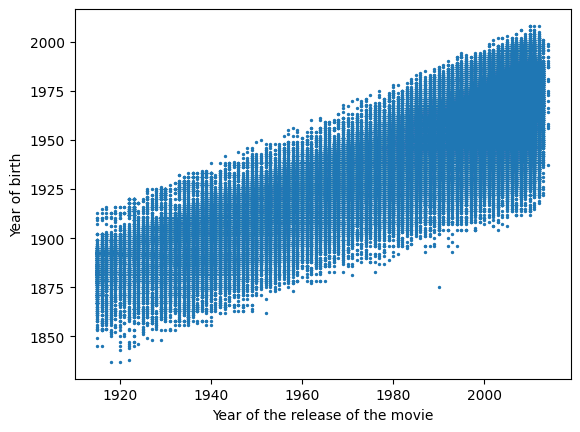

In [22]:
ax = cd_actorYear.plot.scatter(x = 'Year', y = 'Year_of_birth', s = 2)
ax.set_ylabel('Year of birth')
ax.set_xlabel('Year of the release of the movie')

- We conclude this preprocessing by adding a column age interval to classificate the differents categories of actors

In [23]:
categories = ['Baby(0-3)', 'Kid(3-13)', 'Teenager(13-19)', 'Young Actor(19-30)', 'Experimented Actor(30-60)', 'Old Actor(60+)']
cd_actorYear['Age_Interval'] = pd.cut(cd_actorYear['Actor_age_at_movie_release'], bins=[0, 3, 13, 19, 30, 60, 120], labels=categories)
cd_actorYear['Age_Interval'] = cd_actorYear['Age_Interval'].astype(str)

with open(pickle_folder+"characters_clean.p", "wb" ) as f:
    cd = cd_actorYear
    pickle.dump(cd,f)

cd

,Wikipedia_movie_ID,Actor_date_of_birth,Actor_gender,Actor_name,Actor_age_at_movie_release,Movie_name,Movie_release_date,Movie_box_office_revenue,Year,Year_Interval,averageRating,numVotes,release_season,gender_F,gender_M,Year_of_birth,Age_Interval
0,975900,1958-08-26,F,Wanda De Jesus,43,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False,1958,Experimented Actor(30-60)
1,975900,1974-08-15,F,Natasha Henstridge,27,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False,1974,Young Actor(19-30)
2,975900,1969-06-15,M,Ice Cube,32,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,False,True,1969,Experimented Actor(30-60)
3,975900,1967-09-12,M,Jason Statham,34,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,False,True,1967,Experimented Actor(30-60)
4,975900,1977-09-25,F,Clea DuVall,24,Ghosts of Mars,2001-08-24,14010832.0,2001,1995-2015,4.9,58585.0,Summer,True,False,1977,Young Actor(19-30)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271650,913762,1954,M,Sonny Byrkett,38,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,False,True,1954,Experimented Actor(30-60)
271651,913762,1954,M,Sonny Byrkett,38,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,False,True,1954,Experimented Actor(30-60)
271652,913762,1958,F,Susan Byrkett,34,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,True,False,1958,Experimented Actor(30-60)
271654,913762,1970-05,F,Dorothy Elias-Fahn,22,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,1992,1975-1995,NaN,NaN,Spring,True,False,1970,Young Actor(19-30)
